# Table of Contents

- [1. Introduction](#introduction)
- [2. Data Loading](#import-modules)
- [3. Mastermind Game Code](#mastermind-game-code)
- [4. Import Data](#import-data)
- [5. Visualising Bot Intelligence](#visualising-bot-intelligence)
- [6. Model 1: Logistic Regression](#model-1-logistic-regression)
- [7. Model 2: XGBoost](#model-2-xgboost)
- [9. Model 3: XGBoost with Random Search](#model-3-xgboost-with-random-search)
- [10. Model 4: XGBoost with Bayesian Optimisation](#model-4-xgboost-with-bayesian-optimisation)
- [11. Summary](#summary)

# Introduction

The aim of this project is to see how well a machine learning model can classify a set of relatively incompetent bots playing mastermind. A bot playing randomly versus a bot playing optimally would be too easy for a classifier model to identify, so instead, we will construct an algorithm for bots playing at the following three bot intelligence (BI) levels:
* BI 0: random guessing each turn
* BI 1: randomly selecting from allowed moves following previous turn
* BI 2: randomly selecting from allowed moves following best previous turn

After having demonstrated the performance of each of these bots, we will build a logistic regression model to classify which bot was playing given its profile of scores per turn. We will then improve on this by both selecting a more sophisticated model and engaging in some hyperparameter tuning.

Let's begin!

# Import Modules

In [41]:
import numpy as np
import pandas as pd
from random import randint as rand
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
import xgboost as xgb
from scipy.stats import uniform, randint
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Mastermind with Three Levels of Bot Intelligence

The following cell is a modification of a python game I built previously - the main purpose of this part is to illustrate how the training data we will be using model later has been generated.

To aid speed, the total_game_count has been capped at 100.

To see how the bots play each game, ensure that show_games is set to "y".

Game: 1
Bot Intelligence: 0
Solution: ['p', 'y', 'o', 'o']
g b y v--> w
v g g b--> 
y o b b--> ww
g y b y--> r
p p g y--> rw
g p p g--> w
b b y p--> ww
p o v o--> rrw
o b v y--> ww
g p g p--> w
p v g b--> r
y b g v--> w
y v b v--> w
v g y p--> ww
b v o v--> r
v v o b--> r
v g b v--> 
v y b p--> rw
p p b g--> r
p p v g--> r
p b g v--> r
y y p y--> rw
g p p b--> w
p y v y--> rr
b o b b--> w
y v v g--> w
o g y v--> ww
y b v p--> ww
p o v y--> rww
o g g o--> rw
p y o g--> rrr
o p g v--> ww
o y b b--> rw
p o g g--> rw
o p b o--> rww
o y y v--> rw
v b b g--> 
v v b v--> 
g y b b--> r
b v g p--> w
b b y g--> w
b v y b--> w
b g y p--> ww
b b b g--> 
g o o v--> rw
g o p b--> ww
p b p v--> r
v o g p--> ww
g y o b--> rr
v o y v--> ww
p b b g--> r
y g y g--> w
o b v g--> w
b v o o--> rr
o v g o--> rw
o v o b--> rw
p b y v--> rw
o g v y--> ww
v b v p--> w
v v o p--> rw
b o b o--> rw
b v o o--> rr
y b o p--> rww
y y y o--> rr
g y g b--> r
g g g v--> 
v y b v--> r
o p g g--> ww
y y v v--> r
o v g p--

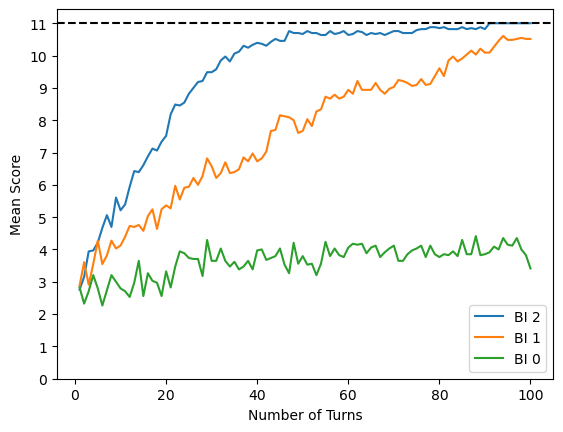

In [ ]:
######### CHOOSE PARAMETERS #########
max_turns = 100
total_game_count = 100
show_games = "y"
#####################################

# create colours
colours = ["y","g","b","p","v","o"]

# helper function that initiates parameters at the start of each game
def initialise_game_state():
    return {
        "row_vector": [],
        "evaluation_vector": [],
        "guess_list": [],
        "evaluation_list": [],
        "score_list": [],
        "current_guess": ["*", "*", "*", "*"],
        "turn_number": 0,
        "solution": [],
        "bot_intelligence": 0,
        "game_end": False
    }

# helper function that prints game board
def print_board(game_state):
    print('\n'.join([m+n for m,n in zip(game_state["row_vector"],game_state["evaluation_vector"])]))

# helper function that returns an evaluation for a given guess
def checker(game_state):
    evaluation = []
    solution = game_state["solution"]
    current_guess = game_state["current_guess"]
    solution_reduced = solution.copy()
    current_guess_reduced = current_guess.copy()
    for i in range(4):
        if current_guess[i] == solution[i]:
            evaluation.append("r")
            solution_reduced[i] = "x"
            current_guess_reduced[i] = "z"
    for i in range(4):
        if current_guess_reduced[i] in solution_reduced:
            evaluation.append("w")
            solution_reduced[solution_reduced.index(current_guess_reduced[i])] = "x"
            current_guess_reduced[i] = "z"
    evaluation = sorted(evaluation)
    game_state["evaluation_list"].append(evaluation)
    return evaluation
    #print(f"Your score is {evaluation}.")

# helper function that scores guesses based on evaluation, allowing evaluations to be ranked
def guess_score(game_state, evaluation):
    if evaluation == []:
        score = 0
    elif evaluation == ["w"]:
        score = 1
    elif evaluation == ["w","w"]:
        score = 2
    elif evaluation == ["r"] or evaluation == ["r","w"]:
        score = 3
    elif evaluation == ["w","w","w"]:
        score = 4
    elif evaluation == ["r","r"] or evaluation == ["r","w","w"]:
        score = 5
    elif evaluation == ["r","r","w"]:
        score = 6
    elif evaluation == ["r","r","r"]:
        score = 7
    elif evaluation == ["w","w","w","w"]:
        score = 8
    elif evaluation == ["r","w","w","w"]:
        score = 9
    elif evaluation == ["r","r","w","w"]:
        score = 10
    elif evaluation == ["r","r","r","r"]:
        score = 11
    game_state["score_list"].append(score)
    return score

# helper function that decides the next move based on the previous evaluation
def next_move_decider(game_state, evaluation):
    #print(f"MY CURRENT MOVE IS {game_state["current_guess"]}")
    #print(f"turn number: {game_state["turn_number"]}")
    if game_state["bot_intelligence"] == 0 or evaluation == []:
        guess_try = [colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)]]
    elif evaluation == ["r","r","r"]:
        guess_try = rrr_function(game_state["current_guess"])[rand(0,3)]
    elif evaluation == ["r"]:
        guess_try = r_function(game_state["current_guess"])[rand(0,3)]
    elif evaluation == ["r","r","w","w"]:
        guess_try = rrww_function(game_state["current_guess"])[rand(0,5)]
    elif evaluation == ["r","r"]:
        guess_try = rr_function(game_state["current_guess"])[rand(0,5)]
    elif evaluation == ["r","w","w","w"]:
        guess_try = rwww_function(game_state["current_guess"])[rand(0,7)]
    elif evaluation == ["w","w","w","w"]:
        guess_try = wwww_function(game_state["current_guess"])[rand(0,8)]
    elif evaluation == ["r","r","w"]:
        guess_try = rrw_function(game_state["current_guess"])[rand(0,11)]
    elif evaluation == ["w"]:
        guess_try = w_function(game_state["current_guess"])[rand(0,11)]
    elif evaluation == ["r","w"]:
        guess_try = rw_function(game_state["current_guess"])[rand(0,23)]
    elif evaluation == ["r","w","w"]:
        guess_try = rww_function(game_state["current_guess"])[rand(0,35)]
    elif evaluation == ["w","w"]:
        guess_try = ww_function(game_state["current_guess"])[rand(0,41)]
    elif evaluation == ["w","w","w"]:
        guess_try = www_function(game_state["current_guess"])[rand(0,46)]
    if guess_try in game_state["guess_list"]:
        next_move_decider(game_state, evaluation)
    return guess_try

### compendium of possible permutations for each evaluation
# rrww --> 6 combinations
def rrww_function(guess):
    moves_rrww = [
        [guess[0],guess[1],guess[3],guess[2]],
        [guess[0],guess[3],guess[2],guess[1]],
        [guess[0],guess[2],guess[1],guess[3]],
        [guess[3],guess[1],guess[2],guess[0]],
        [guess[2],guess[1],guess[0],guess[3]],
        [guess[1],guess[0],guess[2],guess[3]]
        ]
    return moves_rrww

# rwww --> 8 combinations
def rwww_function(guess):
    moves_rwww = [
        [guess[0],guess[3],guess[1],guess[2]],
        [guess[0],guess[2],guess[3],guess[1]],
        [guess[3],guess[1],guess[0],guess[2]],
        [guess[2],guess[1],guess[3],guess[0]],
        [guess[3],guess[0],guess[2],guess[1]],
        [guess[1],guess[3],guess[2],guess[0]],
        [guess[2],guess[0],guess[1],guess[3]],
        [guess[1],guess[2],guess[0],guess[3]]
        ]
    return moves_rwww

# wwww --> 9 combinations
def wwww_function(guess):
    moves_wwww = [
        [guess[3],guess[0],guess[1],guess[2]],
        [guess[3],guess[2],guess[0],guess[1]],
        [guess[3],guess[2],guess[1],guess[0]],
        [guess[2],guess[3],guess[0],guess[1]],
        [guess[2],guess[3],guess[1],guess[0]],
        [guess[2],guess[0],guess[3],guess[1]],
        [guess[1],guess[2],guess[3],guess[0]],
        [guess[1],guess[0],guess[3],guess[2]],
        [guess[1],guess[3],guess[0],guess[2]]
        ]
    return moves_wwww

# rrr --> 4 combinations
def rrr_function(guess):
    moves_rrr = [
        [guess[0],guess[1],guess[2],colours[rand(0,5)]],
        [guess[0],guess[1],colours[rand(0,5)],guess[3]],
        [guess[0],colours[rand(0,5)],guess[2],guess[3]],
        [colours[rand(0,5)],guess[1],guess[2],guess[3]]
        ]
    return moves_rrr

# rrw --> 12 combinations
def rrw_function(guess):
    moves_rrw = [
        [guess[0],guess[1],guess[3],colours[rand(0,5)]],
        [guess[0],guess[1],colours[rand(0,5)],guess[2]],
        [guess[0],guess[3],guess[2],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],guess[2],guess[1]],
        [guess[0],guess[2],colours[rand(0,5)],guess[3]],
        [guess[0],colours[rand(0,5)],guess[1],guess[3]],
        [guess[3],guess[1],guess[2],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[1],guess[2],guess[0]],
        [guess[2],guess[1],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],guess[1],guess[0],guess[3]],
        [guess[1],colours[rand(0,5)],guess[2],guess[3]],
        [colours[rand(0,5)],guess[0],guess[2],guess[3]],
        ]
    return moves_rrw

# rww --> 36 combinations
def rww_function(guess):
    moves_rww = [
        [guess[0],guess[2],guess[1],colours[rand(0,5)]],
        [guess[0],guess[3],guess[1],colours[rand(0,5)]],
        [guess[0],guess[2],guess[3],colours[rand(0,5)]],
        [guess[2],guess[1],guess[0],colours[rand(0,5)]],
        [guess[3],guess[1],guess[0],colours[rand(0,5)]],
        [guess[2],guess[1],guess[3],colours[rand(0,5)]],
        [guess[1],guess[0],guess[2],colours[rand(0,5)]],
        [guess[3],guess[0],guess[2],colours[rand(0,5)]],
        [guess[1],guess[3],guess[2],colours[rand(0,5)]],
        [guess[0],guess[2],colours[rand(0,5)],guess[1]],
        [guess[0],guess[3],colours[rand(0,5)],guess[1]],
        [guess[0],guess[3],colours[rand(0,5)],guess[2]],
        [guess[2],guess[1],colours[rand(0,5)],guess[0]],
        [guess[3],guess[1],colours[rand(0,5)],guess[0]],
        [guess[3],guess[1],colours[rand(0,5)],guess[2]],
        [guess[1],guess[0],colours[rand(0,5)],guess[3]],
        [guess[2],guess[0],colours[rand(0,5)],guess[3]],
        [guess[1],guess[2],colours[rand(0,5)],guess[3]],
        [guess[0],colours[rand(0,5)],guess[1],guess[2]],
        [guess[0],colours[rand(0,5)],guess[3],guess[1]],
        [guess[0],colours[rand(0,5)],guess[3],guess[2]],
        [guess[1],colours[rand(0,5)],guess[2],guess[0]],
        [guess[3],colours[rand(0,5)],guess[2],guess[0]],
        [guess[3],colours[rand(0,5)],guess[2],guess[1]],
        [guess[1],colours[rand(0,5)],guess[0],guess[3]],
        [guess[2],colours[rand(0,5)],guess[0],guess[3]],
        [guess[2],colours[rand(0,5)],guess[1],guess[3]],
        [colours[rand(0,5)],guess[1],guess[0],guess[2]],
        [colours[rand(0,5)],guess[1],guess[3],guess[0]],
        [colours[rand(0,5)],guess[1],guess[3],guess[2]],
        [colours[rand(0,5)],guess[0],guess[2],guess[1]],
        [colours[rand(0,5)],guess[3],guess[2],guess[0]],
        [colours[rand(0,5)],guess[3],guess[2],guess[1]],
        [colours[rand(0,5)],guess[0],guess[1],guess[3]],
        [colours[rand(0,5)],guess[2],guess[0],guess[3]],
        [colours[rand(0,5)],guess[2],guess[1],guess[3]],
        ]
    return moves_rww

# www --> 47 combinations
def www_function(guess):
    moves_www = [
        [guess[2],guess[0],guess[1],colours[rand(0,5)]],
        [guess[1],guess[2],guess[0],colours[rand(0,5)]],
        [guess[2],guess[0],colours[rand(0,5)],guess[1]],
        [guess[1],guess[2],colours[rand(0,5)],guess[0]],
        [guess[1],guess[0],colours[rand(0,5)],guess[2]],
        [guess[1],colours[rand(0,5)],guess[0],guess[2]],
        [guess[2],colours[rand(0,5)],guess[0],guess[1]],
        [guess[2],colours[rand(0,5)],guess[1],guess[0]],
        [colours[rand(0,5)],guess[0],guess[1],guess[2]],
        [colours[rand(0,5)],guess[0],guess[2],guess[1]],
        [colours[rand(0,5)],guess[2],guess[0],guess[1]],
        [colours[rand(0,5)],guess[2],guess[1],guess[0]],
        [guess[1],guess[0],guess[3],colours[rand(0,5)]],
        [guess[1],guess[3],guess[0],colours[rand(0,5)]],
        [guess[3],guess[0],guess[1],colours[rand(0,5)]],
        [guess[1],guess[3],colours[rand(0,5)],guess[0]],
        [guess[3],guess[0],colours[rand(0,5)],guess[1]],
        [guess[1],colours[rand(0,5)],guess[3],guess[0]],
        [guess[3],colours[rand(0,5)],guess[0],guess[1]],
        [guess[3],colours[rand(0,5)],guess[1],guess[0]],
        [colours[rand(0,5)],guess[0],guess[3],guess[1]],
        [colours[rand(0,5)],guess[1],guess[3],guess[0]],
        [colours[rand(0,5)],guess[3],guess[0],guess[1]],
        [colours[rand(0,5)],guess[3],guess[1],guess[0]],
        [guess[2],guess[0],guess[3],colours[rand(0,5)]],
        [guess[2],guess[3],guess[0],colours[rand(0,5)]],
        [guess[3],guess[2],guess[0],colours[rand(0,5)]],
        [guess[2],guess[3],colours[rand(0,5)],guess[0]],
        [guess[3],guess[0],colours[rand(0,5)],guess[2]],
        [guess[3],guess[2],colours[rand(0,5)],guess[0]],
        [guess[2],colours[rand(0,5)],guess[3],guess[0]],
        [guess[3],colours[rand(0,5)],guess[0],guess[2]],
        [colours[rand(0,5)],guess[0],guess[3],guess[2]],
        [colours[rand(0,5)],guess[2],guess[3],guess[0]],
        [colours[rand(0,5)],guess[3],guess[0],guess[2]],
        [colours[rand(0,5)],guess[3],guess[2],guess[0]],
        [guess[1],guess[2],guess[3],colours[rand(0,5)]],
        [guess[2],guess[3],guess[1],colours[rand(0,5)]],
        [guess[3],guess[2],guess[1],colours[rand(0,5)]],
        [guess[1],guess[3],colours[rand(0,5)],guess[2]],
        [guess[2],guess[3],colours[rand(0,5)],guess[1]],
        [guess[3],guess[2],colours[rand(0,5)],guess[1]],
        [guess[1],colours[rand(0,5)],guess[3],guess[2]],
        [guess[2],colours[rand(0,5)],guess[3],guess[1]],
        [guess[3],colours[rand(0,5)],guess[1],guess[2]],
        [colours[rand(0,5)],guess[2],guess[3],guess[1]],
        [colours[rand(0,5)],guess[3],guess[1],guess[2]],
        ]
    return moves_www

# rr --> 6 combinations
def rr_function(guess):
    moves_rr = [
        [guess[0],guess[1],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],guess[2],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],guess[1],guess[2],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[1],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[2],guess[3]]
        ]
    return moves_rr

# rw --> 24 combinations
def rw_function(guess):
    moves_rw = [
        [guess[0],guess[2],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[0],guess[3],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[2],guess[1],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[3],guess[1],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],guess[1],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],guess[3],colours[rand(0,5)]],
        [guess[1],colours[rand(0,5)],guess[2],colours[rand(0,5)]],
        [guess[3],colours[rand(0,5)],guess[2],colours[rand(0,5)]],
        [guess[0],colours[rand(0,5)],colours[rand(0,5)],guess[1]],
        [guess[0],colours[rand(0,5)],colours[rand(0,5)],guess[2]],
        [guess[1],colours[rand(0,5)],colours[rand(0,5)],guess[3]],
        [guess[2],colours[rand(0,5)],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],guess[1],guess[0],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[1],guess[3],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[0],guess[2],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[3],guess[2],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[1],colours[rand(0,5)],guess[0]],
        [colours[rand(0,5)],guess[1],colours[rand(0,5)],guess[2]],
        [colours[rand(0,5)],guess[0],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],guess[2],colours[rand(0,5)],guess[3]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[2],guess[0]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[2],guess[1]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[0],guess[3]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[1],guess[3]]
        ]
    return moves_rw

# ww --> 42 combinations
def ww_function(guess):
    moves_ww = [
        [guess[1],guess[0],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[1],guess[2],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[1],guess[3],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[2],guess[0],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[2],guess[3],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[3],guess[0],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[3],guess[2],colours[rand(0,5)],colours[rand(0,5)]],
        [guess[1],colours[rand(0,5)],guess[0],colours[rand(0,5)]],
        [guess[1],colours[rand(0,5)],guess[3],colours[rand(0,5)]],
        [guess[2],colours[rand(0,5)],guess[0],colours[rand(0,5)]],
        [guess[2],colours[rand(0,5)],guess[1],colours[rand(0,5)]],
        [guess[2],colours[rand(0,5)],guess[3],colours[rand(0,5)]],
        [guess[3],colours[rand(0,5)],guess[0],colours[rand(0,5)]],
        [guess[3],colours[rand(0,5)],guess[1],colours[rand(0,5)]],
        [guess[1],colours[rand(0,5)],colours[rand(0,5)],guess[0]],
        [guess[1],colours[rand(0,5)],colours[rand(0,5)],guess[2]],
        [guess[2],colours[rand(0,5)],colours[rand(0,5)],guess[0]],
        [guess[2],colours[rand(0,5)],colours[rand(0,5)],guess[1]],
        [guess[3],colours[rand(0,5)],colours[rand(0,5)],guess[0]],
        [guess[3],colours[rand(0,5)],colours[rand(0,5)],guess[1]],
        [guess[3],colours[rand(0,5)],colours[rand(0,5)],guess[2]],
        [colours[rand(0,5)],guess[0],guess[1],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[0],guess[3],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[2],guess[0],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[2],guess[1],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[2],guess[3],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[3],guess[0],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[3],guess[1],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[0],colours[rand(0,5)],guess[1]],
        [colours[rand(0,5)],guess[0],colours[rand(0,5)],guess[2]],
        [colours[rand(0,5)],guess[2],colours[rand(0,5)],guess[0]],
        [colours[rand(0,5)],guess[2],colours[rand(0,5)],guess[1]],
        [colours[rand(0,5)],guess[3],colours[rand(0,5)],guess[0]],
        [colours[rand(0,5)],guess[3],colours[rand(0,5)],guess[1]],
        [colours[rand(0,5)],guess[3],colours[rand(0,5)],guess[2]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[0],guess[1]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[0],guess[2]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[1],guess[0]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[1],guess[2]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[3],guess[0]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[3],guess[1]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[3],guess[2]]
        ]
    return moves_ww

# r --> 4 combinations
def r_function(guess):
    moves_r = [
        [guess[0],colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[1],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[2],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)],guess[3]]
        ]
    return moves_r

# w --> 12 combinations
def w_function(guess):
    moves_w = [
        [colours[rand(0,5)],guess[0],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[0],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)],guess[0]],
        [guess[1],colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[1],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)],guess[1]],
        [guess[2],colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[2],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)],guess[2]],
        [guess[3],colours[rand(0,5)],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],guess[3],colours[rand(0,5)],colours[rand(0,5)]],
        [colours[rand(0,5)],colours[rand(0,5)],guess[3],colours[rand(0,5)]]
        ]
    return moves_w

# main function
def play_mastermind(max_turns, total_game_count, show_games):
    game_state = initialise_game_state()
    game_number = 0
    session_summary_df = pd.DataFrame(columns=["Game","Attempts"])
    # prepare output_df for ML
    output_df = pd.DataFrame(columns=np.arange(1,max_turns+2).tolist())
    output_df.columns = [*output_df.columns[:-1],"bot_intelligence"]
    #loop through games
    while game_number < total_game_count:
        game_state = initialise_game_state()
        game_state["bot_intelligence"] = game_number % 3 #(every third game runs the same intelligence level)
        game_number += 1
        game_state["solution"] = [colours[rand(0,5)] for i in range(4)]
        if show_games == "y":
            print(f"Game: {game_number}\nBot Intelligence: {game_state["bot_intelligence"]}\nSolution: {game_state["solution"]}")
        #loop through turns
        while game_state["game_end"] == False:
            game_state["turn_number"] += 1
            if game_state["current_guess"] == ["*","*","*","*"]:
                random_vector = [rand(0,5) for i in range(4)]
                a_s = colours[random_vector[0]]
                b_s = colours[random_vector[1]]
                c_s = colours[random_vector[2]]
                d_s = colours[random_vector[3]]
                game_state["current_guess"] = [a_s,b_s,c_s,d_s]
                #print(f"Guess: {game_state["current_guess"]}")
            evaluation = checker(game_state)
            game_state["row_vector"].append(" ".join(game_state["current_guess"]))
            game_state["evaluation_vector"].append("--> "+"".join(str(i) for i in evaluation))
            score = guess_score(game_state, evaluation)
            if evaluation == ["r","r","r","r"]:
                if show_games == "y":
                    print_board(game_state)
                    print(f"Bot wins with {game_state["turn_number"]} turns!\n")
                session_summary_df.loc[len(session_summary_df)] = [game_number,game_state["turn_number"]]
                if len(game_state["score_list"]) < max_turns:
                    game_state["score_list"].extend([11 for i in range(max_turns-len(game_state["score_list"]))])
                else:
                    game_state["score_list"] = game_state["score_list"][:max_turns]
                game_state["score_list"].append(game_state["bot_intelligence"])
                output_df.loc[len(output_df)] = game_state["score_list"]
                game_state["game_end"] = True
            elif game_state["turn_number"] == max_turns:
                if show_games == "y":
                    print_board(game_state)
                    print("Bot lost.\n")
                session_summary_df.loc[len(session_summary_df)] = [game_number,"Failed"]
                if len(game_state["score_list"]) < max_turns:
                    game_state["score_list"].extend([11 for i in range(max_turns-len(game_state["score_list"]))])
                else:
                    game_state["score_list"] = game_state["score_list"][:max_turns]
                game_state["score_list"].append(game_state["bot_intelligence"])
                output_df.loc[len(output_df)] = game_state["score_list"]
                game_state["game_end"] = True
            else:
                game_state["guess_list"].append(game_state["current_guess"])
                #guess_score(game_state, evaluation)
                if game_state["bot_intelligence"] == 2 and score < max(game_state["score_list"]):
                    guess_try = game_state["guess_list"][game_state["score_list"].index(max(game_state["score_list"]))]
                    evaluation = game_state["evaluation_list"][game_state["score_list"].index(max(game_state["score_list"]))]
                    #print(f'Returning to turn {game_state["score_list"].index(max(game_state["score_list"]))} - having guess {game_state["guess_list"][game_state["score_list"].index(max(game_state["score_list"]))]} and evaluation {game_state["evaluation_list"][game_state["score_list"].index(max(game_state["score_list"]))]}')
                if game_state["turn_number"] > 1:
                    game_state["current_guess"] = guess_try
                guess_try = next_move_decider(game_state, evaluation)
                game_state["current_guess"] = guess_try
                #print(f"Guess: {game_state["current_guess"]}")
                # game_state["guess_list"].append(game_state["current_guess"])
        if game_number == total_game_count:
            if show_games == "y":
                print("-- END OF SESSION --")
            print(session_summary_df)
            #print(f"Mean: {round(session_summary_df.mean()[1],2)}\nStandard Deviation: {round(session_summary_df.std()[1],2)}")
            output_df = output_df.apply(pd.to_numeric)
            print(output_df)
            print(f"Means:\n{output_df.groupby('bot_intelligence',as_index=False)[[i for i in range(1,max_turns+1)]].mean()}")
            to_graph = output_df.groupby('bot_intelligence',as_index=False)[[i for i in range(1,max_turns+1)]].mean().transpose().rename(columns={0:"BI 0",1:"BI 1",2:"BI 2"})
            to_graph.drop(index=to_graph.index[0],axis=0,inplace=True)
            print(to_graph)
            plt.plot(to_graph["BI 2"],label="BI 2")
            plt.plot(to_graph["BI 1"],label="BI 1")
            plt.plot(to_graph["BI 0"],label="BI 0")
            plt.axhline(y=11, color='black', linestyle='--')
            plt.xlabel("Number of Turns")
            plt.ylabel("Mean Score")
            plt.yticks([i for i in range(12)])
            plt.legend(loc="lower right")
            plt.show()
            #print(f'BI 2 Success: {to_graph["BI 2"].tolist().index(11)}')
            #print(f'BI 1 Success: {to_graph["BI 1"].tolist().index(11)}')
            #print(f'BI 0 Success: {to_graph["BI 0"].tolist().index(11)}')

play_mastermind(max_turns, total_game_count, show_games)

# Import Data

We can either use the data just generated as output_df, or alternatively a prepared csv with parameters max_turns=100 and total_game_count=200000.

For now, we will import the csv.

In [9]:
# game_data = output_df
game_data = pd.read_csv('Mastermind_100_Turns.csv')
n_turns = 100

game_data.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,bot_intelligence
0,3,3,3,2,3,3,3,5,1,1,...,5,1,3,5,3,0,2,2,2,0
1,3,6,5,5,3,0,10,10,10,11,...,11,11,11,11,11,11,11,11,11,1
2,5,3,0,5,3,2,5,3,0,3,...,11,11,11,11,11,11,11,11,11,2
3,1,0,3,1,0,3,3,5,3,3,...,0,0,2,2,3,0,6,1,3,0
4,3,1,1,0,3,1,3,2,5,3,...,11,11,11,11,11,11,11,11,11,1


# Visualising the Differences in Bot Intelligence

Let's compare how the mean score increases with turns for each bot intelligence.

Given that we 200000 games in game_data, the lines should have smoothed (but should also still display the same rough trends as before).

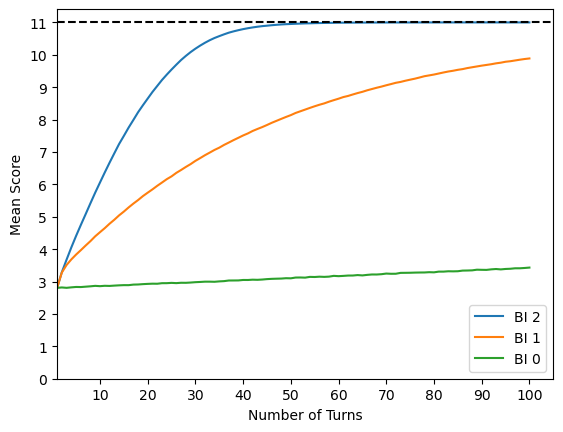

In [5]:
to_graph = game_data.groupby('bot_intelligence',as_index=False)[[str(i) for i in range(1,max_turns+1)]].mean().transpose().rename(columns={0:"BI 0",1:"BI 1",2:"BI 2"})
to_graph.drop(index=to_graph.index[0],axis=0,inplace=True)

fig, ax = plt.subplots()
ax.plot(to_graph["BI 2"],label="BI 2")
ax.plot(to_graph["BI 1"],label="BI 1")
ax.plot(to_graph["BI 0"],label="BI 0")
ax.axhline(y=11, color='black', linestyle='--')
ax.set_xlabel("Number of Turns")
ax.set_xticks(range(-1,100,10))
ax.set_ylabel("Mean Score")
ax.set_yticks([i for i in range(12)])
ax.legend(loc="lower right")
plt.axis(xmin=0)
plt.show()

The bot intelligences are clearly differentiated by the speed at which they approach a perfect score of 11. BI 2 attains this after about 55 turns, while the other bots are still playing catch-up.

Let's now visualise the mean scores across all 100 turns - are there any patterns that distinguish the three bot intelligences clearly?

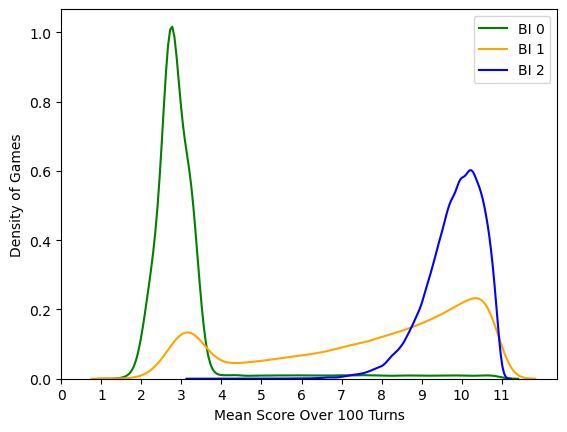

In [10]:
bot_means = [[],[],[]]

# append mean of row, based on BI value (final column)
for i in range(game_data.shape[0]):
    bot_means[game_data.iloc[i,-1]].append(game_data.iloc[i,:-1].mean())

# graph kde plot of means per BI value
fig, ax = plt.subplots()
sns.kdeplot(data=bot_means[0], ax=ax, color="green", label="BI 0")
sns.kdeplot(data=bot_means[1], ax=ax, color="orange", label="BI 1")
sns.kdeplot(data=bot_means[2], ax=ax, color="blue", label="BI 2")
ax.set_xticks([i for i in range(12)])
ax.set_xlabel(f"Mean Score Over {n_turns} Turns")
ax.set_ylabel("Density of Games")
ax.legend(loc="upper right")
plt.show()

BI 0 and BI 2 are clearly separated. Interestingly, BI 1 has two local maxima, with a skew towards higher mean scores. This may be explained by the observation that while BI 1 tends to eventually win, it has a subset of games where it gets stuck in bad guesses (hence the lower maximum). This makes sense, since although BI 1 tries to improve on its current turn, it never takes into account its best prior guess, and so fails to reliably build on its successes.

Given the distinctions identified, we should expect models to clearly separate BI 0 and BI 2, while producing a slighter higher number of false negative predictions for BI 1.

# Model 1: Logistic Regression

Given that we have a classification task at hand, we will use a supervised classification algorithm. We will start with logistic regression, since it is a simpler algorithm that is less prone to overfitting.

Simple models can still overfit, though - so to prevent excess overfitting, we will manually implement early stopping by running logistic regression iteratively so we can evaluate the consecutive loss fall per iteration, relative to a validation set.

After running the algorithm and getting an idea for the ballpark accuracy and loss (as well as model performance for the precision and recall of each bot intelligence), we will then decide whether to further tune the hyperparameters or to try a more sophisticated algorithm.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model

Early stopping activated - iteration 15


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


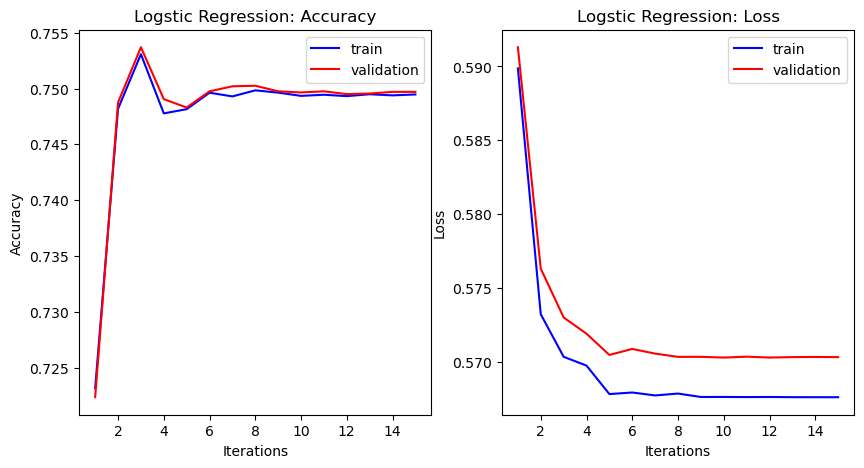

--- Test Set Scores ---
Accuracy: 0.7462
Loss 0.5658279268029855


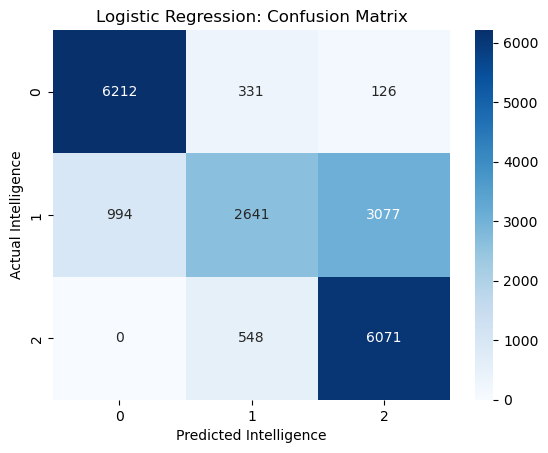

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6669
           1       0.75      0.39      0.52      6712
           2       0.65      0.92      0.76      6619

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.73     20000
weighted avg       0.76      0.75      0.72     20000



In [ ]:

X = game_data.drop(['bot_intelligence'], axis=1)
y = game_data['bot_intelligence']

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=0)

# logistic regression requires scaled features
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

# lists for plotting
accuracy_train_list = []
accuracy_val_list = []
loss_train_list = []
loss_val_list = []
iteration_list = []

# model definition, fitting and prediction
lowest_loss = np.inf
consecutive_loss_fall = 0
for i in range(1, 1000):
    model_1 = LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        max_iter=i,
        warm_start=True, # to keep previous coefficients
        random_state=0
    )

    model_1.fit(X_train, y_train)

    # create data points to plot
    y_hat_train = model_1.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_hat_train)
    accuracy_train_list.append(accuracy_train)
    y_proba_train = model_1.predict_proba(X_train)
    loss_train = log_loss(y_train, y_proba_train)
    loss_train_list.append(loss_train)

    y_hat_val = model_1.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_hat_val)
    accuracy_val_list.append(accuracy_val)
    y_proba_val = model_1.predict_proba(X_val)
    loss_val = log_loss(y_val, y_proba_val)
    loss_val_list.append(loss_val)

    iteration_list.append(i)

    # manual implementation of early stopping
    if loss_val < lowest_loss:
        lowest_loss = loss_val
        consecutive_loss_fall = 0
    else:
        consecutive_loss_fall += 1
    
    if consecutive_loss_fall == 5:
        print(f"Early stopping activated - iteration {i}")
        break
    else:
        continue

# plot curves
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(iteration_list, accuracy_train_list, label="train")
plt.plot(iteration_list, accuracy_val_list, label="validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Logstic Regression: Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iteration_list, loss_train_list, label="train")
plt.plot(iteration_list, loss_val_list, label="validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Logstic Regression: Loss")
plt.legend()

plt.show()

# evaluate with test set, including confusion matrix and classfication report
y_hat_test = model_1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_hat_test)
y_proba_test = model_1.predict_proba(X_test)
loss_test = log_loss(y_test, y_proba_test)
print(f"--- Test Set Scores ---\nAccuracy: {accuracy_test}\nLoss {loss_test}")

test_matrix = confusion_matrix(y_test, y_hat_test)
sns.heatmap(test_matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Intelligence")
plt.ylabel("Actual Intelligence")
plt.title("Logistic Regression: Confusion Matrix")
plt.show()

print(f"Classification Report:\n{classification_report(y_test, y_hat_test)}")

We obtained a reasonable degree of accuracy (at around 0.75) using logistic regression. The model has not significantly overfit the data, since the training and validation loss curves did not continue to diverge in the final iterations before early stopping.

As expected, the confusion matrix shows that the model is quite successful in predicting BI 0 and BI 2, but struggles with BI 1 - in fact, more instances of BI 1 are misclassified as BI 2 than correctly classified as BI 1! This is supported by the low recall for BI 1 in the classification report.

Given that the BI 1 recall underperformance is so dramatic, we will try a different, more sophisticated model next. We will use XGBoost, compared to logistic regression, this should be better at handling any non-linearities, feature interactions and outliers. There are certainly some outliers in our dataset (e.g. lucky first tries!), as well as feature interactions (e.g. BI 2 referring back to the maximum previous evaluation score).

# Model 2: XGBoost

[0]	train-mlogloss:1.05829	train-merror:0.20395	val-mlogloss:1.05862	val-merror:0.20849
[1]	train-mlogloss:1.02098	train-merror:0.20096	val-mlogloss:1.02163	val-merror:0.20429
[2]	train-mlogloss:0.98645	train-merror:0.19950	val-mlogloss:0.98746	val-merror:0.20425
[3]	train-mlogloss:0.95424	train-merror:0.19973	val-mlogloss:0.95556	val-merror:0.20376


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:39:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-mlogloss:0.92439	train-merror:0.19901	val-mlogloss:0.92603	val-merror:0.20261
[5]	train-mlogloss:0.89652	train-merror:0.19804	val-mlogloss:0.89849	val-merror:0.20210
[6]	train-mlogloss:0.87083	train-merror:0.19825	val-mlogloss:0.87301	val-merror:0.20186
[7]	train-mlogloss:0.84641	train-merror:0.19833	val-mlogloss:0.84878	val-merror:0.20196
[8]	train-mlogloss:0.82391	train-merror:0.19735	val-mlogloss:0.82656	val-merror:0.20128
[9]	train-mlogloss:0.80270	train-merror:0.19710	val-mlogloss:0.80566	val-merror:0.20076
[10]	train-mlogloss:0.78262	train-merror:0.19667	val-mlogloss:0.78582	val-merror:0.20053
[11]	train-mlogloss:0.76390	train-merror:0.19609	val-mlogloss:0.76736	val-merror:0.19971
[12]	train-mlogloss:0.74617	train-merror:0.19584	val-mlogloss:0.74987	val-merror:0.19909
[13]	train-mlogloss:0.72943	train-merror:0.19495	val-mlogloss:0.73340	val-merror:0.19825
[14]	train-mlogloss:0.71359	train-merror:0.19421	val-mlogloss:0.71782	val-merror:0.19800
[15]	train-mlogloss:0.69850

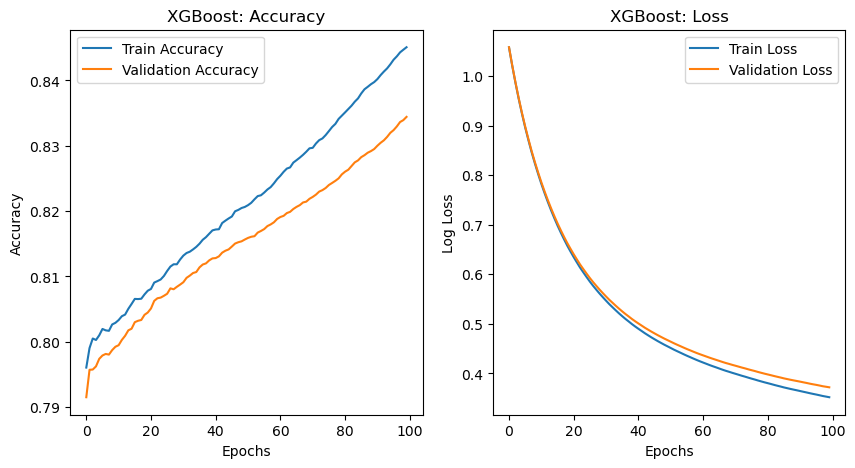

--- Test Set Scores ---
Accuracy: 0.833375


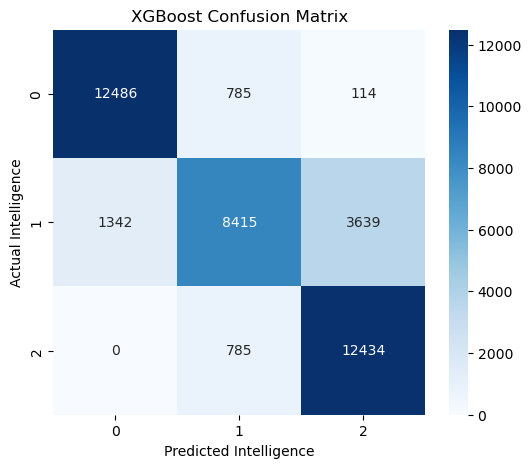

Classfication Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     13385
           1       0.84      0.63      0.72     13396
           2       0.77      0.94      0.85     13219

    accuracy                           0.83     40000
   macro avg       0.84      0.83      0.83     40000
weighted avg       0.84      0.83      0.83     40000



In [24]:
# reset X and y, since feature scalaing not needed
X = game_data.drop(["bot_intelligence"], axis=1)
y = game_data["bot_intelligence"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=0)

# convert data into DMatrix for increased efficiency
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_val = xgb.DMatrix(X_val, label=y_val)
dm_test = xgb.DMatrix(X_test, label=y_test)

model_parameters = {
    "objective": "multi:softmax",
    "num_class": 3,
    "eval_metric": ["mlogloss", "merror"],
    "learning_rate": 0.05,
    "max_depth": 6,
    "n_estimators": 100,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

evals_result = {} # store training history

model_2 = xgb.train(
    model_parameters,
    dm_train,
    num_boost_round=100,
    evals=[(dm_train, "train"), (dm_val, "val")],
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

# plot accuracy and loss curves for training and validation sets
num_epochs = len(evals_result["train"]["mlogloss"])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(num_epochs), 1 - np.array(evals_result["train"]["merror"]), label="Train Accuracy")
plt.plot(range(num_epochs), 1 - np.array(evals_result["val"]["merror"]), label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("XGBoost: Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs), evals_result["train"]["mlogloss"], label="Train Loss")
plt.plot(range(num_epochs), evals_result["val"]["mlogloss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost: Loss")
plt.legend()

plt.show()

# make predictions using test set
y_hat_test = model_2.predict(dm_test)
accuracy_test = accuracy_score(y_test, y_hat_test)
print(f"--- Test Set Scores ---\nAccuracy: {accuracy_test}")

test_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure(figsize=(6,5))
sns.heatmap(test_matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Intelligence")
plt.ylabel("Actual Intelligence")
plt.title("XGBoost Confusion Matrix")
plt.show()

print(f"Classfication Report:\n{classification_report(y_test, y_hat_test)}")

XGBoost is a clear improvement on logistic regression, with an increase in both model accuracy and BI 1 recall. As can be seen on the confusion matrix, BI 1 is now more likely to predict BI 1 correctly.

There are still, however, too many misclassifications of BI 1 as BI 2 - we will address this by adjusting the hyperparameters.

We will use RandomizedSearchCV - this method is quite fast, so will allow us to quickly see if hyperparamter tuning has much effect.

# Model 3: XGBoost with Random Search

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.9390508031418598, gamma=0.1430378732744839, learning_rate=0.19082901282149317, max_depth=6, n_estimators=153, reg_lambda=0.4236547993389047, subsample=1.016715290453325; total time=   0.3s
[CV] END colsample_bytree=0.9390508031418598, gamma=0.1430378732744839, learning_rate=0.19082901282149317, max_depth=6, n_estimators=153, reg_lambda=0.4236547993389047, subsample=1.016715290453325; total time=   0.3s
[CV] END colsample_bytree=0.9390508031418598, gamma=0.1430378732744839, learning_rate=0.19082901282149317, max_depth=6, n_estimators=153, reg_lambda=0.4236547993389047, subsample=1.016715290453325; total time=   0.4s
[CV] END colsample_bytree=0.9390508031418598, gamma=0.1430378732744839, learning_rate=0.19082901282149317, max_depth=6, n_estimators=153, reg_lambda=0.4236547993389047, subsample=1.016715290453325; total time=   0.5s
[CV] END colsample_bytree=0.9544356488751459, gamma=0.1851193276585322

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.1225254007598804, gamma=0.17400242964936385, learning_rate=0.3035855026698292, max_depth=3, n_estimators=227, reg_lambda=0.46147936225293185, subsample=1.1244233410291644; total time=   0.5s
[CV] END colsample_bytree=1.1225254007598804, gamma=0.17400242964936385, learning_rate=0.3035855026698292, max_depth=3, n_estimators=227, reg_lambda=0.46147936225293185, subsample=1.1244233410291644; total time=   0.5s
[CV] END colsample_bytree=1.1225254007598804, gamma=0.17400242964936385, learning_rate=0.3035855026698292, max_depth=3, n_estimators=227, reg_lambda=0.46147936225293185, subsample=1.1244233410291644; total time=   0.4s
[CV] END colsample_bytree=1.1225254007598804, gamma=0.17400242964936385, learning_rate=0.3035855026698292, max_depth=3, n_estimators=227, reg_lambda=0.46147936225293185, subsample=1.1244233410291644; total time=   0.4s
[CV] END colsample_bytree=0.5946195406951466, gamma=0.12798420426550478, learning_rate=0.05300598622271392, max_depth=3, n_e

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
85 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "/opt/anacond

[0]	train-mlogloss:0.88957	train-merror:0.21781	val-mlogloss:0.89082	val-merror:0.21991
[1]	train-mlogloss:0.76000	train-merror:0.21129	val-mlogloss:0.76222	val-merror:0.21343
[2]	train-mlogloss:0.67412	train-merror:0.20584	val-mlogloss:0.67736	val-merror:0.20792
[3]	train-mlogloss:0.61455	train-merror:0.20350	val-mlogloss:0.61890	val-merror:0.20571


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-mlogloss:0.56891	train-merror:0.20083	val-mlogloss:0.57417	val-merror:0.20360
[5]	train-mlogloss:0.53415	train-merror:0.19906	val-mlogloss:0.54041	val-merror:0.20166
[6]	train-mlogloss:0.50735	train-merror:0.19626	val-mlogloss:0.51418	val-merror:0.19916
[7]	train-mlogloss:0.48716	train-merror:0.19496	val-mlogloss:0.49415	val-merror:0.19675
[8]	train-mlogloss:0.47045	train-merror:0.19318	val-mlogloss:0.47812	val-merror:0.19584
[9]	train-mlogloss:0.45545	train-merror:0.18955	val-mlogloss:0.46418	val-merror:0.19257
[10]	train-mlogloss:0.44129	train-merror:0.18734	val-mlogloss:0.45077	val-merror:0.19041
[11]	train-mlogloss:0.42898	train-merror:0.18379	val-mlogloss:0.43921	val-merror:0.18757
[12]	train-mlogloss:0.41712	train-merror:0.18025	val-mlogloss:0.42777	val-merror:0.18501
[13]	train-mlogloss:0.40688	train-merror:0.17775	val-mlogloss:0.41796	val-merror:0.18296
[14]	train-mlogloss:0.39840	train-merror:0.17554	val-mlogloss:0.40994	val-merror:0.18111
[15]	train-mlogloss:0.39096

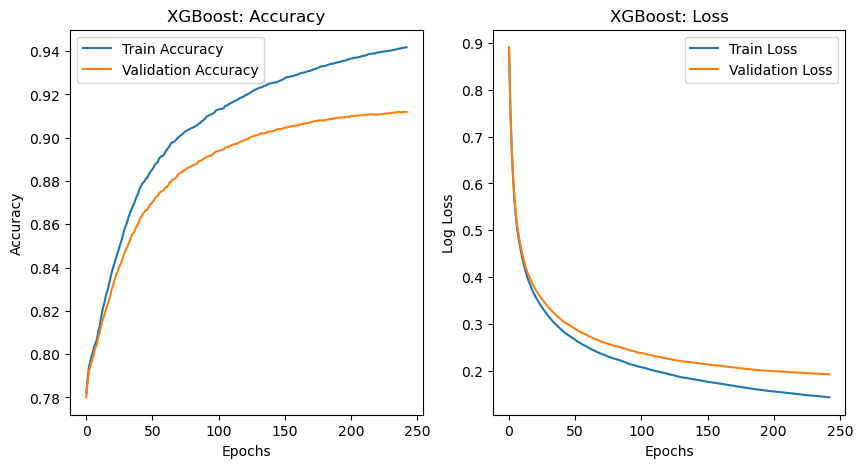

--- Test Set Scores ---
Accuracy: 0.911875


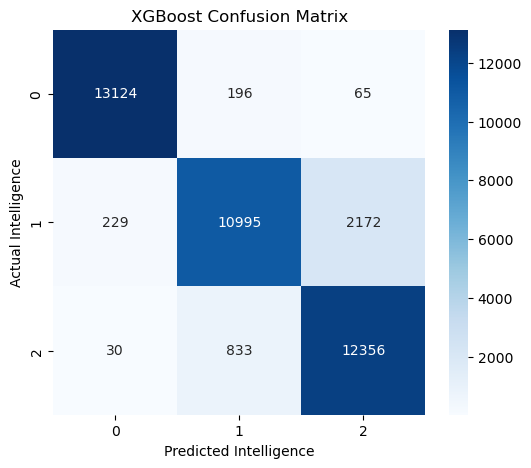

Classfication Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13385
           1       0.91      0.82      0.87     13396
           2       0.85      0.93      0.89     13219

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



In [ ]:
# can use X_tran, dm_train, X_val, dm_val and X_test, dm_test from previous code block

fixed_parameters = {
    "objective": "multi:softmax",
    "num_class": 3,
    "eval_metric": ["mlogloss", "merror"]
}

parameter_distributions = {
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 10),
    "n_estimators": randint(50, 300), # number of boosting rounds
    "subsample": uniform(0.5, 0.8), # sample fraction per tree
    "colsample_bytree": uniform(0.5, 0.8), # feature fraction per tree
    "gamma": uniform(0, 0.2), # min loss reduction
    "reg_lambda": uniform(0, 1) # L2 regularisation
}

# define dummy XGBoost model to facilitate parameter search in it (prior to training)
dummy_model = xgb.XGBClassifier(fixed_parameters)

random_parameter_search = RandomizedSearchCV(
    dummy_model, param_distributions=parameter_distributions,
    n_iter=30, scoring="accuracy", cv=5, verbose=2, random_state=0, n_jobs=-1
)
random_parameter_search.fit(X_train, y_train)

best_model = random_parameter_search.best_estimator_
best_parameters = random_parameter_search.best_params_
best_parameters.update(fixed_parameters)

evals_result = {}

model_3 = xgb.train(
    best_parameters,
    dm_train,
    num_boost_round=best_parameters["n_estimators"],
    evals=[(dm_train, "train"), (dm_val, "val")],
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

# plot accuracy and loss curves for training and validation sets
num_epochs = len(evals_result["train"]["mlogloss"])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(num_epochs), 1 - np.array(evals_result["train"]["merror"]), label="Train Accuracy")
plt.plot(range(num_epochs), 1 - np.array(evals_result["val"]["merror"]), label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("XGBoost: Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs), evals_result["train"]["mlogloss"], label="Train Loss")
plt.plot(range(num_epochs), evals_result["val"]["mlogloss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost: Loss")
plt.legend()

plt.show()

# make predictions using test set
y_hat_test = model_3.predict(dm_test)
accuracy_test = accuracy_score(y_test, y_hat_test)
print(f"--- Test Set Scores ---\nAccuracy: {accuracy_test}")

test_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure(figsize=(6,5))
sns.heatmap(test_matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Intelligence")
plt.ylabel("Actual Intelligence")
plt.title("XGBoost Confusion Matrix")
plt.show()

print(f"Classfication Report:\n{classification_report(y_test, y_hat_test)}")

Hyperparameter tuning has further improved the model, bringing the BI 1 recall closer to that of the other classes (as well as increasing the overall model accuracy above 0.9).

Since this first round of hyperparameter tuning was successful, we will try to optimise them once more with the more computationally demanding Bayesian Optimisation.

# Model 4: XGBoost with Bayesian Optimisation

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:0.88854	train-merror:0.21325	val-mlogloss:0.88976	val-merror:0.21550
[1]	train-mlogloss:0.75966	train-merror:0.21052	val-mlogloss:0.76141	val-merror:0.21247
[2]	train-mlogloss:0.67355	train-merror:0.20733	val-mlogloss:0.67600	val-merror:0.20965
[3]	train-mlogloss:0.61221	train-merror:0.20436	val-mlogloss:0.61533	val-merror:0.20664
[4]	train-mlogloss:0.56824	train-merror:0.20121	val-mlogloss:0.57219	val-merror:0.20316
[5]	train-mlogloss:0.53427	train-merror:0.19846	val-mlogloss:0.53916	val-merror:0.20010


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	train-mlogloss:0.50746	train-merror:0.19554	val-mlogloss:0.51317	val-merror:0.19791
[7]	train-mlogloss:0.48685	train-merror:0.19301	val-mlogloss:0.49328	val-merror:0.19535
[8]	train-mlogloss:0.46946	train-merror:0.19084	val-mlogloss:0.47661	val-merror:0.19396
[9]	train-mlogloss:0.45445	train-merror:0.18907	val-mlogloss:0.46260	val-merror:0.19219
[10]	train-mlogloss:0.44140	train-merror:0.18750	val-mlogloss:0.45029	val-merror:0.19098
[11]	train-mlogloss:0.42931	train-merror:0.18422	val-mlogloss:0.43910	val-merror:0.18834
[12]	train-mlogloss:0.41756	train-merror:0.18118	val-mlogloss:0.42792	val-merror:0.18604
[13]	train-mlogloss:0.40789	train-merror:0.17785	val-mlogloss:0.41876	val-merror:0.18332
[14]	train-mlogloss:0.39817	train-merror:0.17424	val-mlogloss:0.40948	val-merror:0.18014
[15]	train-mlogloss:0.38969	train-merror:0.17165	val-mlogloss:0.40158	val-merror:0.17767
[16]	train-mlogloss:0.38138	train-merror:0.16841	val-mlogloss:0.39384	val-merror:0.17509
[17]	train-mlogloss:0.375

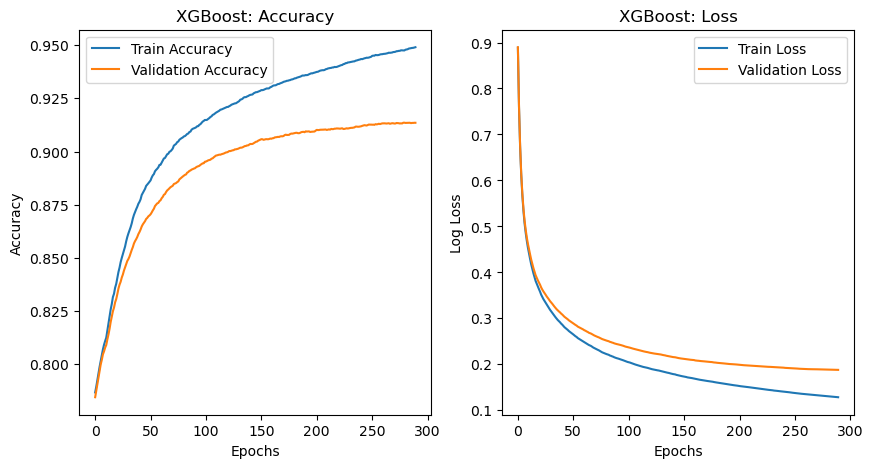

--- Test Set Scores ---
Accuracy: 0.91445


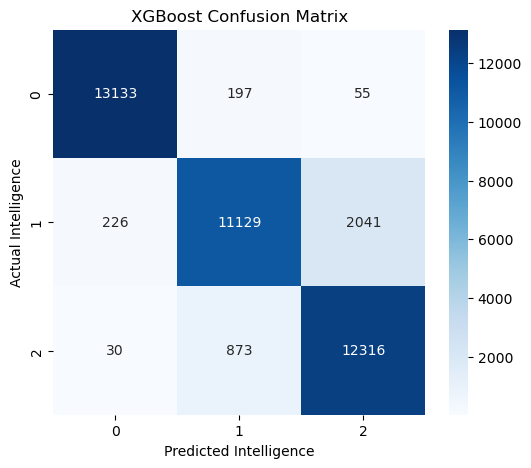

Classfication Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13385
           1       0.91      0.83      0.87     13396
           2       0.85      0.93      0.89     13219

    accuracy                           0.91     40000
   macro avg       0.92      0.91      0.91     40000
weighted avg       0.92      0.91      0.91     40000



In [36]:
# need to use skopt for BayesSearchCV, instead of scipy.stats

parameter_distributions = {
    'learning_rate': Real(0.01, 0.3),
    'max_depth': Integer(3, 10),
    'n_estimators': Integer(50, 300), # num of boosting rounds
    'subsample': Real(0.5, 0.8), # sample fraction per tree
    'colsample_bytree': Real(0.5, 0.8), # feature fraction per tree
    'gamma': Real(0, 0.2), # min loss reduction
    'reg_lambda': Real(0, 1) # L2 regularisation
}

dummy_model = xgb.XGBClassifier(fixed_parameters)

bayesian_parameter_search = BayesSearchCV(
    dummy_model, parameter_distributions,
    n_iter=50, scoring="accuracy", cv=5, n_jobs=-1
)
bayesian_parameter_search.fit(X_train, y_train)

best_model = bayesian_parameter_search.best_estimator_
best_parameters = bayesian_parameter_search.best_params_
best_parameters.update(fixed_parameters)

evals_result = {}

model_4 = xgb.train(
    best_parameters,
    dm_train,
    num_boost_round=best_parameters["n_estimators"],
    evals=[(dm_train, "train"), (dm_val, "val")],
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

# plot accuracy and loss curves for training and validation sets
num_epochs = len(evals_result["train"]["mlogloss"])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(num_epochs), 1 - np.array(evals_result["train"]["merror"]), label="Train Accuracy")
plt.plot(range(num_epochs), 1 - np.array(evals_result["val"]["merror"]), label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("XGBoost: Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs), evals_result["train"]["mlogloss"], label="Train Loss")
plt.plot(range(num_epochs), evals_result["val"]["mlogloss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost: Loss")
plt.legend()

plt.show()

# make predictions using test set
y_hat_test = model_4.predict(dm_test)
accuracy_test = accuracy_score(y_test, y_hat_test)
print(f"--- Test Set Scores ---\nAccuracy: {accuracy_test}")

test_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure(figsize=(6,5))
sns.heatmap(test_matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Intelligence")
plt.ylabel("Actual Intelligence")
plt.title("XGBoost Confusion Matrix")
plt.show()

print(f"Classfication Report:\n{classification_report(y_test, y_hat_test)}")

Improvements in model performance were marginal this time - so we will no longer push XGBoost with further hyperparameter tuning.

However, given the difficulties Model 1 had with identifying BI 1, we have made some major improvements to this point!

# Summary

We constructed an algorithm that lets three kinds of bot play the game mastermind.
BI 0: random guessing each turn
BI 1: randomly selecting from allowed moves following previous turn
BI 2: randomly selecting from allowed moves following best previous turn

All three of these bots perform worse than a human familiar with the rules of mastermind, since they do not combine the evaluations of more than one turn - as a result, all three may be difficult to distinguish initially.

A clear trend emerges after tens of thosands of iterations - the average score of BI 2 reaches its maximum value after about 50 turns, with BI 1 and BI 0 catching up at a progressively slower pace respectively. BI 1, though, can exhibit some less predictable behaviour - sometimes it wins quickly, by chance, whilst other times, it takes longer.

Logistic regression does a good job at separating BI 0 and BI 2, but struggles with BI 1, given its bimodal distribution. XGBoost with hyperparameter tuning performs much better, yielding higher accuracy overall, and mitigating some of the misclassification of BI 1.

Suggestions for future exploration:
* Vary the maximum number of turns each bot can make - how much does model performance improve if bots are allowed to take 1000 turns (and so become more distinguishable)? How about if they can only take 8 turns, like in classic mastermind - can the model distinguish them at all?
* Export game states or evaluations instead of just scores - does this improve model performance?